### APPLIED DATA SCIENCE CAPSTONE 

## CAR ACCIDENT SEVERITY REPORT

## Introduction
### Business Problem

One of the leading causes of death and injury across the United States are traffic accidents. In order to better understand the potential impacts (and possibly mitigate them), we will be looking at predicting the severity of a car accident based upon several attributes. To localize the scope of this study, we will be evaluating accident statistics for the municipality of Seattle, Washington.

This report will be of particular interest to drivers, city planners, emergency responders and insurance providers.

### Data

This data is maintained by the Seattle Police Department and contains records of every traffic accident from 2004 to the present, updated on a weekly basis. This dataset (contained in a .csv file) contains information such as:
- the severity of the accident
- type of collision
- number of fatalities and/or injuries
- weather conditions
- road conditions
- any pedestrians or non-automobiles involved
and other factors.

The dataset can be found at: https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv and the metadata can be found at https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf.

We will be particularly interested in how weather/road conditions, attentiveness/impairment of the driver and pedestrian/non-automobile involvement plays into traffic accident severity. Are there correlations betwwen poor weather conditions and severity? Does the presence of pedestrians make an accident better or worse? How do road conditions affect accident severity? These are some of the questions we hope to be able to answer in this project.

We will be performing the following:
- an exploratory data analysis to determine which variables are needed to construct a machine learning model
- choose an appropriate model for which to conduct the study
- training the model
- testing the model, and finally 
- calculating the effectiveness of our model.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
# Import Dataset
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df.head()
print('Data file successfully loaded!');

Data file successfully loaded!


C:\Users\azkia\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Data Understanding<a name="data"></a>

Our predictor or target variable will be 'SEVERITYCODE' because it is used to measure the severity of an accident from 0 to 4 within the dataset. Attributes used to weigh the severity of an accident are 'WEATHER', 'ROADCOND' and 'LIGHTCOND'.

Severity codes are as follows:

* 0 : Little to no Probability (Clear Conditions)
* 1 : Very Low Probability - Chance or Property Damage
* 2 : Low Probability - Chance of Injury
* 3 : Mild Probability - Chance of Serious Injury
* 4 : High Probability - Chance of Fatality

### Data Preparation

In it's original form, this data is not fit for analysis. For one, there are many columns that we will not use for this mode. We must use label encoding to covert the features to our desired data type.

In [3]:
# Drop all columns with no predictive value for the context of this project
colData = df.drop(columns = ['OBJECTID', 'SEVERITYCODE.1', 'REPORTNO', 'INCKEY', 'COLDETKEY', 
              'X', 'Y', 'STATUS','ADDRTYPE',
              'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
              'EXCEPTRSNDESC', 'SEVERITYDESC', 'INCDATE',
              'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
              'SDOT_COLDESC', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
              'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY',
              'CROSSWALKKEY', 'HITPARKEDCAR', 'PEDCOUNT', 'PEDCYLCOUNT',
              'PERSONCOUNT', 'VEHCOUNT', 'COLLISIONTYPE',
              'SPEEDING', 'UNDERINFL', 'INATTENTIONIND'])

# Label Encoding
# Convert column to category
colData["WEATHER"] = colData["WEATHER"].astype('category')
colData["ROADCOND"] = colData["ROADCOND"].astype('category')
colData["LIGHTCOND"] = colData["LIGHTCOND"].astype('category')

# Assign variable to new column for analysis
colData["WEATHER_CAT"] = colData["WEATHER"].cat.codes
colData["ROADCOND_CAT"] = colData["ROADCOND"].cat.codes
colData["LIGHTCOND_CAT"] = colData["LIGHTCOND"].cat.codes

colData.head(5)

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEATHER_CAT,ROADCOND_CAT,LIGHTCOND_CAT
0,2,Overcast,Wet,Daylight,4,8,5
1,1,Raining,Wet,Dark - Street Lights On,6,8,2
2,1,Overcast,Dry,Daylight,4,0,5
3,1,Clear,Dry,Daylight,1,0,5
4,2,Raining,Wet,Daylight,6,8,5


 check the data types of the new columns in our dataframe.

In [4]:
colData.dtypes

SEVERITYCODE        int64
WEATHER          category
ROADCOND         category
LIGHTCOND        category
WEATHER_CAT          int8
ROADCOND_CAT         int8
LIGHTCOND_CAT        int8
dtype: object

#### Analyzing Value Counts

In [5]:
colData["SEVERITYCODE"].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [6]:
colData["WEATHER"].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [7]:
colData["ROADCOND"].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [8]:
colData["LIGHTCOND"].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

#### Balancing the Dataset

downsampling the majority class.

In [9]:
from sklearn.utils import resample

In [10]:
# Seperate majority and minority classes
colData_majority = colData[colData.SEVERITYCODE==1]
colData_minority = colData[colData.SEVERITYCODE==2]

#Downsample majority class
colData_majority_downsampled = resample(colData_majority,
                                        replace=False,
                                        n_samples=58188,
                                        random_state=123)

# Combine minority class with downsampled majority class
colData_balanced = pd.concat([colData_majority_downsampled, colData_minority])

# Display new class counts
colData_balanced.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

## Methodology <a name="methodology"></a>

In this project we will normalize the data. Data standardization or normalization give data zero mean and unit variance. In the first section, data has been preprocessed and features are extracted from the data according to the perspective of the stakeholders. We will then build our machine learning models based on the features. Here three machine learning models are compared:

* K-Nearest Neighbor
* Decision Tree
* Logistic Regression

##### K-Nearest Neighbor (KNN)
KNN will help us predict the severity code of an outcome by finding the most similar to data point within k distance.
##### Decision Tree
A decision tree model gives us a layout of all possible outcomes so we can fully analyze the consequences of a decision. It context, the decision tree observes all possible outcomes of different weather conditions.
##### Logistic Regression
Because our dataset only provides us with two severity code outcomes, our model will only predict one of those two classes. This makes our data binary, which is perfect to use with logistic regression.

#### Normalize Data

In [11]:
import numpy as np
X = np.asarray(colData_balanced[['WEATHER_CAT', 'ROADCOND_CAT', 'LIGHTCOND_CAT']])
X[0:5]

array([[ 6,  8,  2],
       [ 1,  0,  5],
       [10,  7,  8],
       [ 1,  0,  5],
       [ 1,  0,  5]], dtype=int8)

In [12]:
y = np.asarray(colData_balanced['SEVERITYCODE'])
y [0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [13]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.15236718,  1.52797946, -1.21648407],
       [-0.67488   , -0.67084969,  0.42978835],
       [ 2.61416492,  1.25312582,  2.07606076],
       [-0.67488   , -0.67084969,  0.42978835],
       [-0.67488   , -0.67084969,  0.42978835]])

#### Classification

Stratification is used to split train and test data to ensure both has the same distribution of data.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (81463, 3) (81463,)
Test set: (34913, 3) (34913,)


#### GRAPH

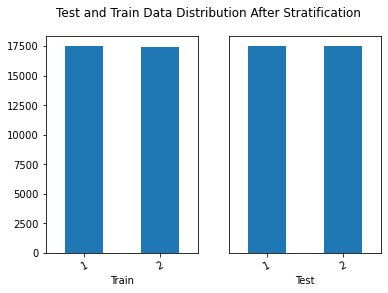

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ytest_ = pd.DataFrame(list(y_test))
ytest_[0].value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels([1,2,0,3,4],rotation=25)
ax1.set_xlabel('Train')
ytrain_ = pd.DataFrame(list(y_train))
ytrain_ = ytrain_[0].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xticklabels([1,2,0,3,4],rotation=25)
ax2.get_yaxis().set_ticks([])
ax2.set_xlabel('Test')
fig.suptitle('Test and Train Data Distribution After Stratification')
plt.show()

### RESULT & EVALUATION <a name="results"></a>

#### Build K-Nearest Neighbor

Best accuracy for KNN:  0.5608799014693667  k:  13


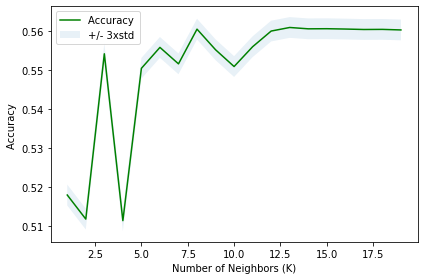

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

##### KNN
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for k in range(1,Ks):
    kNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    yhat= kNN.predict(X_test)
    mean_acc[k-1] = accuracy_score(y_test, yhat)
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
k = np.where(mean_acc == max(mean_acc))[0][0]+1
print('Best accuracy for KNN: ',max(mean_acc), ' k: ', k)

# See the plot for the best k
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Build the KNN model with the best k
kNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

In [44]:
import numpy as np
X = np.asarray(colData_balanced[['WEATHER_CAT', 'ROADCOND_CAT', 'LIGHTCOND_CAT']])
X[0:5]

array([[ 6,  8,  2],
       [ 1,  0,  5],
       [10,  7,  8],
       [ 1,  0,  5],
       [ 1,  0,  5]], dtype=int8)

In [45]:
y = np.asarray(colData_balanced['SEVERITYCODE'])
y [0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [ ]:
### Normalize dataset

In [46]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.15236718,  1.52797946, -1.21648407],
       [-0.67488   , -0.67084969,  0.42978835],
       [ 2.61416492,  1.25312582,  2.07606076],
       [-0.67488   , -0.67084969,  0.42978835],
       [-0.67488   , -0.67084969,  0.42978835]])

In [72]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [30]:
# Building the KNN Model
from sklearn.neighbors import KNeighborsClassifier

k = 25

In [31]:
#Train Model & Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

Kyhat = neigh.predict(X_test)
Kyhat[0:5]

array([2, 2, 1, 1, 2], dtype=int64)

In [71]:
# Jaccard Score
jaccard_score(y_test, Kyhat)

0.27837299706077556

In [70]:
# F1-SCORE
f1_score(y_test, Kyhat, average='macro')

0.5401775308974308

#### Decision Tree

In [35]:
##### Decision Tree
depth = 15
mean_acc = np.zeros((depth-1))
std_acc = np.zeros((depth-1))
for d in range(1,depth):
    crashTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    crashTree.fit(X_train,y_train)
    predTree = crashTree.predict(X_test)
    mean_acc[d-1] = accuracy_score(y_test, predTree)

depth = np.where(mean_acc == max(mean_acc))[0][0]+1
print('Best accuracy for Decision Tree: ',max(mean_acc), ' depth: ', depth)
# Build the Decision Tree model with the best depth
crashTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth).fit(X_train,y_train)



Best accuracy for Decision Tree:  0.5660069315154813  depth:  1


In [47]:
# Train Model & Predict
DTyhat = colDataTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

[2 2 1 1 2]
[2 2 1 1 1]


In [68]:
# Jaccard Score
jaccard_score(y_test, DTyhat)

0.2873687679487783

In [69]:
# F1-SCORE
f1_score(y_test, DTyhat, average='macro')

0.5450597937389444

#### Logistic Regression

In [36]:
##### Logistic Regression
C_param_range = [0.001,0.01,0.1,1,10,100]

mean_acc = np.zeros((len(C_param_range)))
std_acc = np.zeros((len(C_param_range)))

for c in range(len(C_param_range)):
    LR = LogisticRegression(C=C_param_range[c], solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    mean_acc[c-1] = accuracy_score(y_test, yhat)
    std_acc[c-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
c_max = C_param_range[np.where(mean_acc == max(mean_acc))[0][0]]
print('Logistic Regression\'s best acc: ',max(mean_acc), ' Regularization Values: ', c_max)

#Build the Logistic Regression model with max performance
LR = LogisticRegression(C=c_max, solver='liblinear').fit(X_train,y_train)

Logistic Regression's best acc:  0.5260791109328903  Regularization Values:  100


In [48]:
# Building the LR Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=6, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=6, solver='liblinear')

In [49]:
# Train Model & Predicr
LRyhat = LR.predict(X_test)
LRyhat

array([1, 2, 1, ..., 2, 2, 2], dtype=int64)

In [50]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.57295252, 0.42704748],
       [0.47065071, 0.52934929],
       [0.67630201, 0.32369799],
       ...,
       [0.46929132, 0.53070868],
       [0.47065071, 0.52934929],
       [0.46929132, 0.53070868]])

In [62]:
from sklearn.metrics import jaccard_score
#from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss, precision_score, recall_score

report = {}
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [63]:
# Jaccard Similarity Score
jaccard_score(y_test, Kyhat)

0.27837299706077556

In [54]:
# F1-SCORE
f1_score(y_test, LRyhat, average='macro')

0.511602093963383

In [55]:
# LOGLOSS
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.6849535383198887

In [64]:
# Jaccard Similarity Score
jaccard_score(y_test, DTyhat)

0.2873687679487783

In [57]:
# F1-SCORE
f1_score(y_test, DTyhat, average='macro')

0.5450597937389444

In [65]:
# Jaccard Similarity Score
jaccard_score(y_test, LRyhat)

0.2720073907879108

In [58]:
# F1-SCORE
f1_score(y_test, LRyhat, average='macro')

0.511602093963383

In [59]:
# LOGLOSS
yhat_prob = LR.predict_proba(X_test)
log_loss(y_test, yhat_prob)

0.6849535383198887

#### REPORT

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
from sklearn.metrics import jaccard_score, f1_score, log_loss, precision_score, recall_score

report = {}

# KNN
yhat_knn= kNN.predict(X_test)
report['KNN']=[jaccard_score(y_test, yhat_knn),f1_score(y_test, yhat_knn, average='macro'),'NA', precision_score(y_test, yhat_knn, average='macro'), recall_score(y_test, yhat_knn, average='macro')]

# Decision Tree
yhat_tree = crashTree.predict(X_test)
report['Decision Tree']=[jaccard_score(y_test, yhat_tree),f1_score(y_test, yhat_tree, average='macro'),'NA', precision_score(y_test, yhat_tree, average='macro'), recall_score(y_test, yhat_tree, average='macro')]

# Logistic Regression
yhat_lr = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
report['Logistic Regression']=[jaccard_score(y_test, yhat_lr),f1_score(y_test, yhat_lr, average='macro'),log_loss(y_test, yhat_prob), precision_score(y_test, yhat_lr, average='macro'), recall_score(y_test, yhat_lr, average='macro')]

report = pd.DataFrame(report).transpose()
report.reset_index(inplace=True)
report.columns = ['Algorithm','Jaccard','F1-score','LogLoss','Precision', 'Recall']
report

,Algorithm,Jaccard,F1-score,LogLoss,Precision,Recall
0,KNN,0.309508,0.548248,NA,0.5679,0.560429
1,Decision Tree,0.0948271,0.428923,NA,0.707873,0.542194
2,Logistic Regression,0.272007,0.511602,0.684954,0.528919,0.525558


### Discussion <a name="discussion"></a>

In the beginning, we had categorical data that was of type 'object'. This is not a data type that we could have fed through an algorithm, so label encoding was used to created new classes that were of type int8; a numerical data type.

After solving that issue we were presented with another - imbalanced data. The solution to this was downsampling the majority class with sklearn's resample tool. We downsampled to match the minority class exactly with 58188 values each. 

Once we analyzed and cleaned the data, it was then fed through three ML models; K-Nearest Neighbor, Decision Tree and Logistic Regression. Although the first two are ideal for this project, logistic regression made the most sense because of its binary nature.

Evaluation metrics used to test the accuracy of our models were jaccard index, f-1 score and logloss for logistic regression. Choosing different k, max depth and hyperamater C values helped to improve our accuracy to be the best possible.
After the experiments are done, it is found that Jaccard's index calculation in sklearn is different for multiclass, making it calculate the same as accuracy value. Hence, it is advised to build a custom calculation for Jaccard index in multiclass classification. 

To optimize the selection of features, using PCA is advisable to fasten the process of prominent feature selection.

### Conclusion <a name="conclusion"></a>

Based on historical data from weather conditions pointing to certain classes, we can conclude that particular weather conditions have a somewhat impact on whether or not travel could result in property damage (class 1) or injury (class 2).

Based on Seattle GeoData for car collisions, among 40 attributes which has a potential value in predicting car crash severity, human intoxication factor is still the highest feature importance that take part in severity of car accidents. Among environment conditions, weather is imperative to contribute in car collisions, while location of the collision, such as junctions, are exceptionally insignificant. To predict whether collision will affect traffic, with the state of property damage to severity that leads to fatal injuries of the accident, it could be classified effectively using kNN, which had performed better than Decision Tree or Logistic Regression in comparison using 5 evaluation metrics.